In [1]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torchvision
from DLBio.pytorch_helpers import get_device
import numpy as np
import matplotlib.pyplot as plt
import ds_ear_siamese
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss, val_iteration, val_loss):
    plt.plot(iteration,loss, label='train_loss')
    plt.plot(val_iteration,val_loss, label='val_loss')
    plt.legend()
    plt.grid()

In [3]:
# Set Up All Configurations here
class Config():
    NN_SIAMESE = False
    dataset_dir = '../dataset_low_res/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    valid_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 100
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 1

    TRESHOLD_VER = 0.8
    a = 0

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))
n_20 = int(round(.2*N))
n_10 = int(round(.1*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
val_indices = rand_indices[n_70:n_70+n_20]
test_indices = rand_indices[n_70+n_20:]


# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform?
    should_invert = False
)

val_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=val_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    should_invert = False
)
# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    should_invert = False
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    should_invert = False
)

['falco_len', 'janna_qua', 'jesse_kru', 'johannes_boe', 'johannes_wie', 'konrad_von', 'mila_wol', 'nils_loo', 'sarah_feh', 'tim_moe']
800


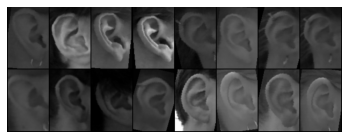

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)
    
    layers = []
    for layer in model.features[0]:
        layers.append(layer)
    model.features[0][0] = nn.ReflectionPad2d(1)
    model.features[0][1] = layers[0]
    model.features[0][2] = layers[1]
    model.features[0].add_module('3', layers[2])
    
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
    
    #model = torch.nn.Sequential(*(list(model.children())[:-1]))
    #model = model.features

else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


In [7]:
# To Define which Layers we want to train
for param in model.parameters():
    param.requires_grad = False

layers = list(model.children())[0]
sub_layer = list(layers.children())
unfreezed = [16,17, 18]
for u in unfreezed:
    for param in sub_layer[u].parameters():
        param.requires_grad = True

In [8]:
# To show trainable parameters
from DLBio.pytorch_helpers import get_num_params

get_num_params(model,True)

1206080

322189331

Epoch number 10
 Current loss 1.076525092124939

Epoch number 10
 Current loss 1.194165825843811

Epoch number 10
 Current Validation loss 3.0841658115386963

Epoch number 10
 Current Validation loss 9.212875366210938

Epoch number 11
 Current loss 1.0874900817871094

Epoch number 11
 Current loss 0.8759926557540894

Epoch number 11
 Current Validation loss 1.2515668869018555

Epoch number 11
 Current Validation loss 1.1192708015441895

Epoch number 12
 Current loss 1.0728507041931152

Epoch number 12
 Current loss 0.8772680759429932

Epoch number 12
 Current Validation loss 20.806800842285156

Epoch number 12
 Current Validation loss 1.870156168937683

Epoch number 13
 Current loss 0.9086742997169495

Epoch number 13
 Current loss 0.8483413457870483

Epoch number 13
 Current Validation loss 1.1305067539215088

Epoch number 13
 Current Validation loss 0.8349642753601074

Epoch number 14
 Current loss 0.9023102521896362

Epoch number 14
 Current loss 1.1693356037139893

Epoch

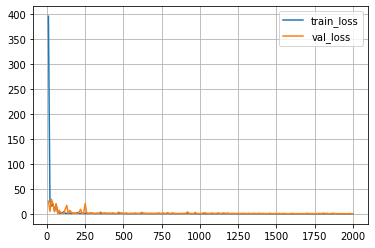

In [9]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE, )

counter, loss_history, val_counter, val_loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history,val_counter, val_loss_history)

In [10]:
if Config.NN_SIAMESE:
    def generate_output( img_in, img_in2):
        if cuda.is_available():
            return model(Variable(img_in).cuda(), Variable(img_in2).cuda())
        else:
            return model(Variable(img_in), Variable(img_in2))

else:
    def generate_output( img_in):
        if cuda.is_available():
            return model(Variable(img_in).cuda())
        else:
            return model(Variable(img_in))         

In [11]:
iter_batches = iter(test_dataloader)
accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    if Config.NN_SIAMESE:
        match_out1, match_out2 = generate_output(m[0], m[1])
        non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    else:
        match_out1 = generate_output(m[0])
        match_out2 = generate_output(m[1])                 
        non_match_out1 = generate_output(n[0])
        non_match_out2 = generate_output(n[1])
        
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < Config.TRESHOLD_VER): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format( 100 * accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     1.536
pos-neg:     2.434
Acc. count:  0 

pos-pos:     0.447
pos-neg:     0.450
Acc. count:  1 

pos-pos:     1.986
pos-neg:     1.347
Acc. count:  1 

pos-pos:     0.480
pos-neg:     0.264
Acc. count:  2 

pos-pos:     0.640
pos-neg:     0.634
Acc. count:  3 

pos-pos:     3.223
pos-neg:     0.834
Acc. count:  3 

pos-pos:     1.092
pos-neg:     1.126
Acc. count:  3 

pos-pos:     3.155
pos-neg:     2.753
Acc. count:  3 

pos-pos:     0.314
pos-neg:     0.638
Acc. count:  4 

pos-pos:     0.714
pos-neg:     1.088
Acc. count:  5 

pos-pos:     1.775
pos-neg:     0.297
Acc. count:  5 

pos-pos:     0.411
pos-neg:     2.507
Acc. count:  6 

pos-pos:     0.592
pos-neg:     2.865
Acc. count:  7 

pos-pos:     2.175
pos-neg:     0.539
Acc. count:  7 

pos-pos:     1.473
pos-neg:     0.750
Acc. count:  7 

pos-pos:     0.699
pos-neg:     2.523
Acc. count:  8 

pos-pos:     2.014
pos-neg:     0.182
Acc. count:  8 

pos-pos:     0.715
pos-neg:     2.959
Acc. count:  9 

pos-pos:  

In [12]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [13]:
#torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model_MN_1.pt')